In [5]:
from typing import Tuple, TypeVar, Dict, Any, List

from collections import defaultdict

import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from scipy.stats import cauchy
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from tqdm import tqdm

%config InlineBackend.figure_format = 'svg'

SklearnClass = TypeVar("SklearnClass") # The class itself (e.g. DecisionTreeRegressor)
SklearnModel = TypeVar("SklearnModel") # A class instance (e.g. DecisionTreeRegressor(max_depth=1))    

In [2]:
random_seed = 42
np.random.seed(random_seed)

In [3]:
deep_grey = '#3B4856' # основной тёмный / холодный цвет
sky_blue = '#348FEA'
marine_green = '#4CB9C0'
grass_green = '#97C804'
medium_yellow = '#FFC100' # основной светлый / тёплый цвет
sicilian_orange = '#E06A27'
fuchsia_pink = '#C81D6B'
saturated_violet = '#5002A7'
navy_blue = '#292183'
cool_white = '#F5FBFF'

$\newcommand{\Var}{\operatorname{\mathbb{V}}}$
$\newcommand{\Exp}{\operatorname{\mathbb{E}}}$
$\newcommand{\eps}{\varepsilon}$

Предположим, что мы решаем задачу регрессии с квадратичной функцией потерь. При использовании квадратичной функции потерь для оценки качества работы алгоритма $a$ можно использовать следующий функционал:

$$
    Q(a) = \Exp_x \Exp_{X, \eps} [y(x, \eps) - a(x, X)]^2,
$$

где 

- $X$ — обучающая выборка 
- $x$ — точка из тестового множества 
- $y = f(x) + \eps$ — целевая зависимость, которую мы можем измерить с точностью до случайного шума $\eps$
- $a(x, X)$ — значение алгоритма, обученного на выборке $X$, в точке $x$
- $\Exp_x$ — среднее по всем тестовым точкам и $\Exp_{X, \eps}$ — среднее по всем обучающим выборкам $X$ и случайному шуму $\eps$

<u> Bias-variance decomposition </u>. Существует представление $Q(a)$ в виде трёх компонент:

$$
    Q(a) = \Exp_x \text{bias}_X^2 a(x, X) + \Exp_x \Var_X[a(x, X)] + \sigma^2,
$$

где

$$
    \text{bias}_X a(x, X) = f(x) - \Exp_X[a(x, X)]
$$

* **смещение** предсказания алгоритма в точке $x$, усреднённого по всем возможным обучающим выборкам, относительно истинной зависимости $f$,

$$
    \Var_X[a(x, X)] = \Exp_X \left[ a(x, X) - \Exp_X[a(x, X)] \right]^2
$$

* **дисперсия (разброс)** предсказаний алгоритма в зависимости от обучающей выборки $X$,

$$
    \sigma^2 = \Exp_x \Exp_\eps[y(x, \eps) - f(x)]^2
$$ 

* неустранимый **шум** в данных.

# Bias-variance для случайных деревьев разной глубины

Попробуем вычислить разложение на смещение и разброс на каком-нибудь практическом примере.

In [4]:
def f(x: np.ndarray) -> np.ndarray:
    return x * np.sin(x)


def generate_data(n_samples: int = 50, noise: float = 3, n_noise_samples: int = 1) -> Tuple[np.ndarray, np.ndarray]:
    x = np.random.rand(n_samples) * 20 - 10
    x = np.sort(x)

    y = np.zeros((n_samples, n_noise_samples))
    for i in range(n_noise_samples):
        y[:, i] = f(x) + np.random.normal(0.0, noise, n_samples)

    return x.reshape((n_samples, 1)), y.squeeze()

Наши обучающие и тестовые примеры будут состоять из зашумлённых значений целевой функции $f(x)$, определённой выше. В качестве шума добавляется нормальный шум с нулевым средним и дисперсией $\sigma^2$, равной во всех дальнейших примерах 9. Такое большое значение шума задано для того, чтобы задача была достаточно сложной для классификатора, который будет на этих данных учиться и тестироваться.

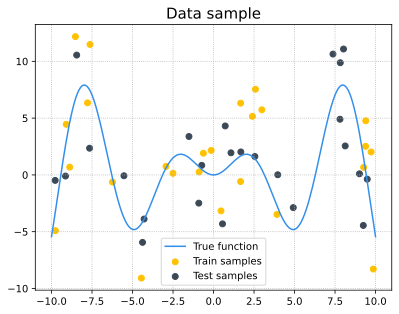

In [9]:
x, y = generate_data(noise=3)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

plt.figure(dpi=150)
plt.title('Data sample', fontsize=15)
xs = np.linspace(-10, 10, num=201)
plt.plot(xs, f(xs), color=sky_blue, label="True function")
plt.scatter(x_train, y_train, color=medium_yellow, label="Train samples")
plt.scatter(x_test, y_test, color=deep_grey, label="Test samples")
plt.legend()
plt.grid(ls=":")

In [10]:
def train_classifier_on_random_subset(clf_class: SklearnClass, parameters: Dict[str, Any], 
                                      n_train_samples: int = 20, noise: float = 3) -> Tuple[SklearnModel, List[np.ndarray]]:

    x_train, y_train = generate_data(n_samples=n_train_samples, noise=noise)
    clf = clf_class(**parameters)
    clf.fit(x_train, y_train)
    return clf, x_train, y_train

Посмотрим на то, как предсказания деревьев зависят от обучающих подмножеств и максимальной глубины дерева.

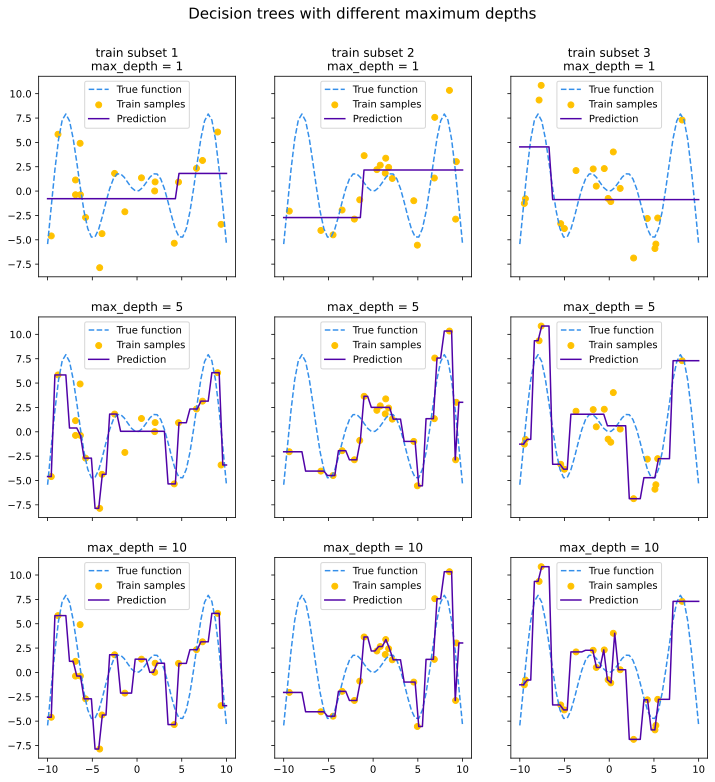

In [14]:
classifiers = [
   [DecisionTreeRegressor, {"max_depth": 1}],
   [DecisionTreeRegressor, {"max_depth": 5}],
   [DecisionTreeRegressor, {"max_depth": 10}],
]
n_tries = 3
x_ticks = np.linspace(-10, 10)
n_rows, n_cols = len(classifiers), n_tries
fig, ax = plt.subplots(n_rows, n_cols, figsize=(4 * n_rows, 4 * n_cols), dpi=150, sharex=True, sharey=True)
fig.subplots_adjust(top=0.9)
fig.suptitle("Decision trees with different maximum depths", fontsize=15)

for i, (clf_class, parameters) in enumerate(classifiers):
    np.random.seed(random_seed) # To make training subsets be identical for all classifiers
    for j in range(n_tries):
        clf, x_train, y_train = train_classifier_on_random_subset(
          clf_class=clf_class, parameters=parameters, noise=3
        )
        prediction = clf.predict(x_ticks[:, None])

        ax[i, j].plot(x_ticks, f(x_ticks), color=sky_blue, label="True function", linestyle="--")
        ax[i, j].scatter(x_train, y_train, color=medium_yellow, label="Train samples")
        ax[i, j].plot(x_ticks, prediction, color=saturated_violet, label="Prediction")
        title = "max_depth = {max_depth}".format(**parameters)
        if i == 0:
            title = f"train subset {j + 1}\n" + title
        ax[i, j].set_title(title)
        ax[i, j].legend()

Для обучения деревьев насемплируем $1000$ случайных подмножеств $X_{\mathrm{train}} = (x_{\mathrm{train}}, y_{\mathrm{train}})$ размера $500$, а для тестирования зафиксируем случайное тестовое подмножество точек $x_{\mathrm{test}}$ также размера $500$. Чтобы вычислить матожидание по $\eps$, нам нужно несколько экземпляров шума $\eps$ для тестовых лейблов: 

$$
y_{\mathrm{test}} = y(x_{\mathrm{test}}, \hat \eps) = f(x_{\mathrm{test}}) + \hat \eps.
$$

Положим количество семплов случайного шума равным $300$. Для фиксированных $X_{\mathrm{train}} = (x_{\mathrm{train}}, y_{\mathrm{train}})$ и $X_{\mathrm{test}} = (x_{\mathrm{test}}, y_{\mathrm{test}})$ квадратичная ошибка вычисляется как

$$
    \mathrm{MSE} = (y_{\mathrm{test}} - a(x_{\mathrm{test}}, X_{\mathrm{train}}))^2
$$

Взяв среднее от $\mathrm{MSE}$ по $X_{\mathrm{train}}$, $x_{\mathrm{test}}$ и $\eps$, мы получим оценку для $Q(a)$, а оценки для компонент ошибки мы получим по ранее выведенным формулам. 

In [15]:
def get_predictions(
    classifiers: List[Tuple[SklearnClass, Dict[str, Any]]], 
    n_tries: int, noise: float, n_train_samples: int, 
    n_test_samples: int, n_noise_samples: int) -> List[Dict[int, Any]]:
  
    x_test, y_test = generate_data(n_samples=n_test_samples, 
                                 n_noise_samples=n_noise_samples, noise=noise)
    predictions = defaultdict(list)

    for i, (clf_class, parameters) in enumerate(classifiers):
        np.random.seed(random_seed)
        for j in tqdm(range(n_tries), desc=f"{clf_class.__name__}, {parameters}"):
            clf, _, _ = train_classifier_on_random_subset(
                clf_class=clf_class, parameters=parameters, 
                n_train_samples=n_train_samples,
                noise=noise
            )
            predictions[i].append(clf.predict(x_test))

    results = []
    for i, (clf_class, parameters) in enumerate(classifiers):
        results.append({
        "name": clf_class.__name__,
        "parameters": parameters,
        "predictions": np.stack(predictions[i]),
        "x_test": x_test,
        "y_test": y_test
        })
  
    return results

In [16]:
classifiers = [[DecisionTreeRegressor, {"max_depth": depth}] for depth in range(1, 16)]

results = get_predictions(
    classifiers,
    n_tries=1000, 
    n_test_samples=500, 
    n_train_samples=500,
    n_noise_samples=300,
    noise=3
)

DecisionTreeRegressor, {'max_depth': 1}: 100%|█| 1000/1000 [00:01<00:00, 905.99i
DecisionTreeRegressor, {'max_depth': 2}: 100%|█| 1000/1000 [00:01<00:00, 721.08i
DecisionTreeRegressor, {'max_depth': 3}: 100%|█| 1000/1000 [00:01<00:00, 686.73i
DecisionTreeRegressor, {'max_depth': 4}: 100%|█| 1000/1000 [00:01<00:00, 728.73i
DecisionTreeRegressor, {'max_depth': 5}: 100%|█| 1000/1000 [00:01<00:00, 645.96i
DecisionTreeRegressor, {'max_depth': 6}: 100%|█| 1000/1000 [00:01<00:00, 780.94i
DecisionTreeRegressor, {'max_depth': 7}: 100%|█| 1000/1000 [00:01<00:00, 754.33i
DecisionTreeRegressor, {'max_depth': 8}: 100%|█| 1000/1000 [00:01<00:00, 741.54i
DecisionTreeRegressor, {'max_depth': 9}: 100%|█| 1000/1000 [00:01<00:00, 756.99i
DecisionTreeRegressor, {'max_depth': 10}: 100%|█| 1000/1000 [00:01<00:00, 605.24
DecisionTreeRegressor, {'max_depth': 11}: 100%|█| 1000/1000 [00:01<00:00, 621.26
DecisionTreeRegressor, {'max_depth': 12}: 100%|█| 1000/1000 [00:01<00:00, 673.27
DecisionTreeRegressor, {'max

In [17]:
print(f"predictions shape: n_tries × n_test_samples = {results[0]['predictions'].shape}")
print(f"x_test shape: n_test_samples × 1 = {results[0]['x_test'].shape}")
print(f"y_test shape: n_test_samples × n_noise_samples = {results[0]['y_test'].shape}")

predictions shape: n_tries × n_test_samples = (1000, 500)
x_test shape: n_test_samples × 1 = (500, 1)
y_test shape: n_test_samples × n_noise_samples = (500, 300)


Вычислим компоненты разложения ошибки для каждого из классификаторов.

In [18]:
def get_bias_variance(results: Dict[str, Any]) -> pd.DataFrame:
    records = []
    for res in results:
        x_test, y_test = res["x_test"], res["y_test"]
        predictions = res["predictions"]
        bias = f(x_test).squeeze() - np.mean(predictions, axis=0)
        variance = np.var(predictions, axis=0)
        noise = np.var(y_test, axis=1)
        error = (predictions[..., None] - y_test[None]) ** 2

        records.append({
            "name": res["name"],
            "parameters": res["parameters"],
            "bias_sq": np.mean(bias ** 2),
            "variance": np.mean(variance),
            "noise": np.mean(noise),
            "error": np.mean(error),
            "decomposition": np.mean(bias ** 2 + variance + noise)
        })
    
    return pd.DataFrame.from_records(records)

In [19]:
get_bias_variance(results)

,name,parameters,bias_sq,variance,noise,error,decomposition
0,DecisionTreeRegressor,{'max_depth': 1},9.538297,1.659189,8.971014,20.168596,20.168500
1,DecisionTreeRegressor,{'max_depth': 2},5.085339,1.650574,8.971014,15.740351,15.706927
2,DecisionTreeRegressor,{'max_depth': 3},2.129631,2.077819,8.971014,13.215631,13.178464
3,DecisionTreeRegressor,{'max_depth': 4},0.423197,1.748217,8.971014,11.174658,11.142428
4,DecisionTreeRegressor,{'max_depth': 5},0.145411,1.829574,8.971014,10.976485,10.945999
5,DecisionTreeRegressor,{'max_depth': 6},0.038503,2.521282,8.971014,11.558981,11.530799
6,DecisionTreeRegressor,{'max_depth': 7},0.010943,3.398563,8.971014,12.406634,12.380520
7,DecisionTreeRegressor,{'max_depth': 8},0.005651,4.316676,8.971014,13.319238,13.293341
8,DecisionTreeRegressor,{'max_depth': 9},0.004788,5.222042,8.971014,14.224752,14.197845
9,DecisionTreeRegressor,{'max_depth': 10},0.005301,6.046255,8.971014,15.049358,15.022570


Нарисуем все три компоненты ошибки и саму ошибку на одном графике.

In [22]:
def plot_bias_variance(bias_variance_results: pd.DataFrame, 
                       target_parameter_name: str,  target_parameter_values: List[float]) -> None:
    plt.figure(figsize=(8, 5), dpi=150)
    plt.xticks(target_parameter_values)
    plt.plot(target_parameter_values, bias_variance_results.bias_sq, label="$\mathbb{E}_x bias_X^2$", color=navy_blue)
    plt.plot(target_parameter_values, bias_variance_results.variance, label="$\mathbb{E}_x variance_X$", color=sicilian_orange)
    plt.plot(target_parameter_values, bias_variance_results.noise, label="$\sigma^2$", color=grass_green)
    plt.plot(target_parameter_values, bias_variance_results.error, label="MSE", color=marine_green)
    plt.xlabel(target_parameter_name)
    plt.legend(fontsize=10, loc="upper right")
    plt.grid(ls=":")
    plt.show()

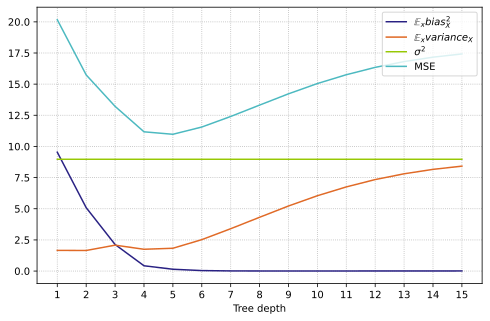

In [23]:
bias_variance_trees = get_bias_variance(results)
depth = bias_variance_trees.apply(lambda r: r.parameters["max_depth"], axis=1)

plot_bias_variance(bias_variance_trees, target_parameter_name="Tree depth",  target_parameter_values=depth)

Видно, что при увеличении глубины деревьев смещение падает практически до нуля, а разброс нарастает. Правда, если взять достаточно много деревьев, разброс тоже станет постоянным:

In [24]:
classifiers = [[DecisionTreeRegressor, {"max_depth": depth}] for depth in range(1, 26)]

results = get_predictions(
    classifiers,
    n_tries=1000, 
    n_test_samples=500, 
    n_train_samples=500,
    n_noise_samples=300,
    noise=3
)

DecisionTreeRegressor, {'max_depth': 1}: 100%|█| 1000/1000 [00:01<00:00, 999.33i
DecisionTreeRegressor, {'max_depth': 2}: 100%|█| 1000/1000 [00:00<00:00, 1005.37
DecisionTreeRegressor, {'max_depth': 3}: 100%|█| 1000/1000 [00:02<00:00, 487.36i
DecisionTreeRegressor, {'max_depth': 4}: 100%|█| 1000/1000 [00:01<00:00, 944.42i
DecisionTreeRegressor, {'max_depth': 5}: 100%|█| 1000/1000 [00:01<00:00, 844.59i
DecisionTreeRegressor, {'max_depth': 6}: 100%|█| 1000/1000 [00:01<00:00, 845.60i
DecisionTreeRegressor, {'max_depth': 7}: 100%|█| 1000/1000 [00:01<00:00, 757.93i
DecisionTreeRegressor, {'max_depth': 8}: 100%|█| 1000/1000 [00:01<00:00, 762.77i
DecisionTreeRegressor, {'max_depth': 9}: 100%|█| 1000/1000 [00:01<00:00, 688.44i
DecisionTreeRegressor, {'max_depth': 10}: 100%|█| 1000/1000 [00:01<00:00, 707.86
DecisionTreeRegressor, {'max_depth': 11}: 100%|█| 1000/1000 [00:01<00:00, 676.12
DecisionTreeRegressor, {'max_depth': 12}: 100%|█| 1000/1000 [00:01<00:00, 549.15
DecisionTreeRegressor, {'max

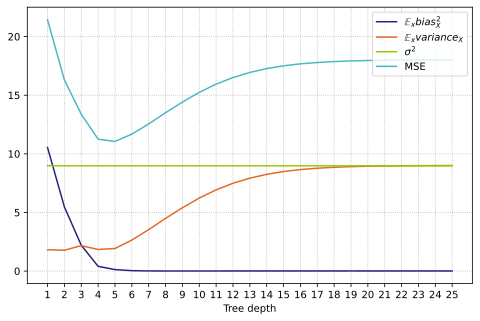

In [25]:
bias_variance_many_trees = get_bias_variance(results)
plot_bias_variance(
    bias_variance_many_trees, target_parameter_name="Tree depth",  
    target_parameter_values=bias_variance_many_trees.apply(lambda r: r.parameters["max_depth"], axis=1)
)

# Bias-variance для бэггинга

Попробуем посмотреть, как выглядят предсказания деревьев глубины 7 и бэггинга над такими деревьями в зависимости от обучающей выборки. Поскольку бэггинг by-design семплирует себе случайные подмножества, мы будем передавать ему на вход 10 000 случайных примеров, из которых он 10 раз (столько деревьев мы включим в ансамбль) насемплирует обучающие подмножества размера 20. Деревья также будут обучаться на 20 примерах.

In [35]:
class BaggingOnTrees(BaggingRegressor):
    def __init__(self, max_depth: int, max_samples: int, n_estimators: int):
        self.max_depth = max_depth
        base_estimator = DecisionTreeRegressor(max_depth=max_depth)
        super().__init__(estimator=base_estimator, max_samples=max_samples, n_estimators=n_estimators)

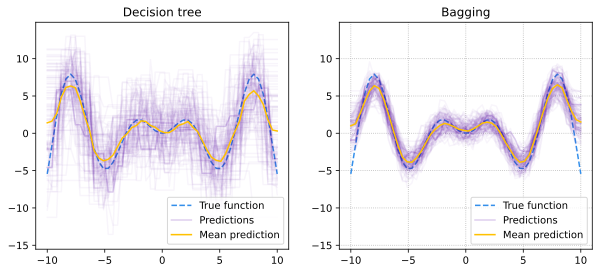

In [36]:
def plot_many_predictions(axs, x_ticks: np.ndarray, clf_class: SklearnClass, 
                          parameters: Dict[str, Any], n_tries: int, n_train_samples: int,
                          title: str) -> None:
  
    axs.plot(x_ticks, f(x_ticks), color=sky_blue, label="True function", linestyle="--")
    np.random.seed(random_seed)
    predictions = []
    for j in range(n_tries):
        clf, _, _ = train_classifier_on_random_subset(
          clf_class=clf_class, parameters=parameters, noise=3,
          n_train_samples=n_train_samples
        )
        prediction = clf.predict(x_ticks[:, None])
        predictions.append(prediction)
        if j == 0:
            axs.plot(x_ticks, prediction, color=saturated_violet, alpha=0.2, label="Predictions")
        else:
            axs.plot(x_ticks, prediction, color=saturated_violet, alpha=0.04)

    axs.plot(x_ticks, np.mean(np.stack(predictions), axis=0), label="Mean prediction", color=medium_yellow)
    axs.set_title(title)
    axs.legend(loc="lower right")


n_tries = 100
x_ticks = np.linspace(-10, 10)
n_rows, n_cols = 1, 2
fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 4), dpi=150, sharey=True)
fig.subplots_adjust(top=0.9)

plot_many_predictions(
        axs=ax[0], x_ticks=x_ticks, clf_class=DecisionTreeRegressor, 
        parameters={"max_depth": 7}, 
        n_tries=n_tries, n_train_samples=20, 
        title="Decision tree"
)

plot_many_predictions(
        axs=ax[1], x_ticks=x_ticks, clf_class=BaggingOnTrees,
        parameters={"max_samples": 20, "n_estimators": 10, "max_depth": 7}, 
        n_tries=n_tries, n_train_samples=10000,
        title="Bagging",
)
ax[1].yaxis.set_tick_params(labelbottom=True)

plt.grid(ls=":")

По графикам кажется, что общая дисперсия предсказаний в зависимости от обучающего множества у бэггинга значительно ниже, а в среднем предсказания деревьев и бэггинга не отличаются. Убедимся, что эти наблюдения верны с помощью bias-variance decomposition.

Попробуем посмотреть, как будет выглядеть bias-variance для бэггинга над деревьями в зависмости от глубины входящих в бэггинг деревьев.

In [37]:
classifiers = [[BaggingOnTrees, {"max_samples": 500, "n_estimators": 10, "max_depth": depth}] for depth in range(1, 16)]

results = get_predictions(
    classifiers, 
    n_tries=100, 
    n_test_samples=500, 
    n_train_samples=10000,
    n_noise_samples=300,
    noise=3
)

BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 1}: 100%|█
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 2}: 100%|█
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 3}: 100%|█
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 4}: 100%|█
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 5}: 100%|█
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 6}: 100%|█
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 7}: 100%|█
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 8}: 100%|█
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 9}: 100%|█
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 10}: 100%|
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 11}: 100%|
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 12}: 100%|
BaggingOnTrees, {'max_sample

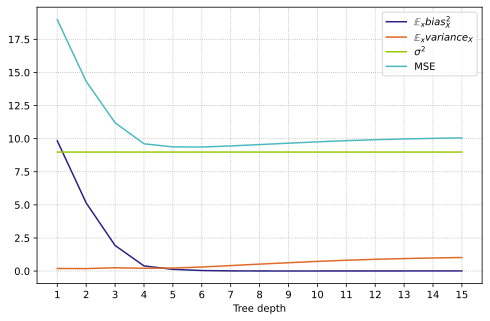

In [38]:
bias_variance_bagging = get_bias_variance(results)
plot_bias_variance(
    bias_variance_bagging, target_parameter_name="Tree depth",  
    target_parameter_values=bias_variance_bagging.apply(lambda r: r.parameters["max_depth"], axis=1)
)

Видно, что дисперсия у бэггинга гораздо ниже, чем была у единичных деревьев, а разброс выглядит почти так же. Для того, чтобы в этом точно убедиться, сравним смещения и разбросы деревьев и бэггинга на разных графиках.

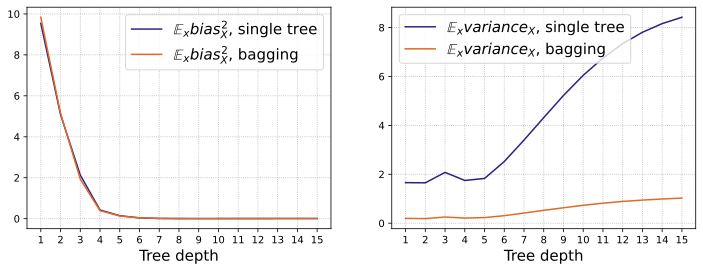

In [44]:
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(12, 4))

ax[0].set_xticks(depth)
ax[0].plot(depth, bias_variance_trees.bias_sq, label="$\mathbb{E}_x bias_X^2$, single tree", color=navy_blue)
ax[0].plot(depth, bias_variance_bagging.bias_sq, label="$\mathbb{E}_x bias_X^2$, bagging", color=sicilian_orange)
ax[0].set_xlabel("Tree depth", fontsize=15)
ax[0].legend(fontsize=15)
ax[0].grid(ls=":")

ax[1].set_xticks(depth)
ax[1].plot(depth, bias_variance_trees.variance, label="$\mathbb{E}_x variance_X$, single tree", color=navy_blue)
ax[1].plot(depth, bias_variance_bagging.variance, label="$\mathbb{E}_x variance_X$, bagging", color=sicilian_orange)
ax[1].set_xlabel("Tree depth", fontsize=15)
ax[1].legend(fontsize=15)
ax[1].grid(ls=":")

На графике видно, как значительно беггинг сократил дисперсию. На самом деле, дисперсия уменьшилась практически в 10 раз, что равняется числу моделей, которые бэггинг использовал для предсказания.

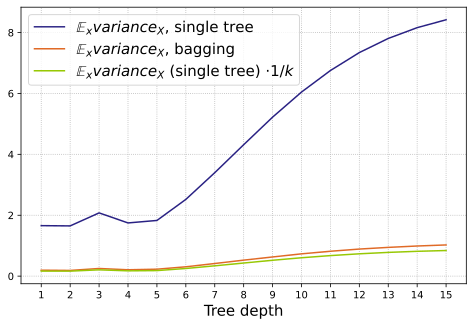

In [47]:
plt.figure(dpi=150, figsize=(8, 5))
plt.xticks(depth)
plt.plot(depth, bias_variance_trees.variance, label="$\mathbb{E}_x variance_X$, single tree", color=navy_blue)
plt.plot(depth, bias_variance_bagging.variance, label="$\mathbb{E}_x variance_X$, bagging", color=sicilian_orange)
plt.plot(depth, bias_variance_trees.variance / 10, label="$\mathbb{E}_x variance_X$ (single tree) $\cdot 1 / k$", color=grass_green)
plt.xlabel("Tree depth", fontsize=15)
plt.legend(fontsize=15)
plt.grid(ls=":")

## Random forest

Random forest is bagging on decision trees. We can build such ensemble explicitely.

In [56]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error

# Load the California Housing dataset as an example
data = fetch_california_housing(as_frame=True)
X = data.data
y = data.target
data['data'].head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [58]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((16512, 8), (4128, 8))

In [61]:
# Create a base decision tree regressor
base_model = DecisionTreeRegressor(random_state=42)

# Create a Bagging Regressor with 100 base models (decision trees)
bagging_model = BaggingRegressor(base_model, n_estimators=100, random_state=42)

# Train the Bagging Regressor on the training data
bagging_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = bagging_model.predict(X_test)

# Evaluate the model's performance
train_mse = mean_squared_error(y_train, bagging_model.predict(X_train))
test_mse = mean_squared_error(y_test, y_pred)

print(f"Train MSE: {train_mse:.4f}")
print(f"Train R-score: {bagging_model.score(X_train, y_train):.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R-score: {bagging_model.score(X_test, y_test):.4f}")

Train MSE: 0.0354
Train R-score: 0.9736
Test MSE: 0.2559
Test R-score: 0.8047


Alternatively, use random forest model:

In [63]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor with 100 trees (estimators)
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest Regressor on the training data
rf_regressor.fit(X_train, y_train)

train_mse = mean_squared_error(y_train, rf_regressor.predict(X_train))
test_mse = mean_squared_error(y_test, rf_regressor.predict(X_test))

print(f"Train MSE: {train_mse:.4f}")
print(f"Train R-score: {rf_regressor.score(X_train, y_train):.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R-score: {rf_regressor.score(X_test, y_test):.4f}")

Train MSE: 0.0353
Train R-score: 0.9736
Test MSE: 0.2554
Test R-score: 0.8051


The metrics are almost identical. Now search for the optimal hyperparameters:

In [66]:
for n_estimators in [10, 50, 200, 1000]:
    for max_depth in range(10, 51, 10):
        RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
        RF.fit(X_train, y_train)
        print(f"n={n_estimators}, depth={max_depth}, train_score={RF.score(X_train, y_train):.4f}, test_score={RF.score(X_test, y_test):.4f}")

n=10, depth=10, train_score=0.8677, test_score=0.7665
n=10, depth=20, train_score=0.9590, test_score=0.7769
n=10, depth=30, train_score=0.9617, test_score=0.7835
n=10, depth=40, train_score=0.9611, test_score=0.7870
n=10, depth=50, train_score=0.9629, test_score=0.7850
n=50, depth=10, train_score=0.8704, test_score=0.7708
n=50, depth=20, train_score=0.9708, test_score=0.8038
n=50, depth=30, train_score=0.9724, test_score=0.8033
n=50, depth=40, train_score=0.9719, test_score=0.8029
n=50, depth=50, train_score=0.9716, test_score=0.7998
n=200, depth=10, train_score=0.8728, test_score=0.7771
n=200, depth=20, train_score=0.9725, test_score=0.8071
n=200, depth=30, train_score=0.9741, test_score=0.8068
n=200, depth=40, train_score=0.9739, test_score=0.8080
n=200, depth=50, train_score=0.9742, test_score=0.8075
n=1000, depth=10, train_score=0.8725, test_score=0.7755
n=1000, depth=20, train_score=0.9732, test_score=0.8084
n=1000, depth=30, train_score=0.9747, test_score=0.8077
n=1000, depth=40,